In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Minas Gerais - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_MG.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Minas Gerais - IDH,Minas Gerais - Consumo de Cimento (t),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Minas Gerais - value,Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Minas Gerais - PIB - Per Capita,Minas Gerais - PIB - Preços de Mercado
0,2003-1,0.756537,247.134,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.334536,648.891160,8.242462,2.937752e+08,1.725077e+07,14.096054,2.759117e+08
1,2003-2,0.756708,305.708,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.335670,652.396314,8.236470,2.941480e+08,1.726959e+07,14.102603,2.760648e+08
2,2003-3,0.756879,284.168,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.336553,655.911573,8.230479,2.945208e+08,1.728841e+07,14.109152,2.762178e+08
3,2003-4,0.757050,286.594,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.336531,656.746430,8.224488,2.948935e+08,1.730723e+07,14.115701,2.763709e+08
4,2003-5,0.757222,312.455,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.336406,660.114672,8.218497,2.952663e+08,1.732605e+07,14.122250,2.765239e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,633.858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.622619,1250.988075,NaN,NaN,NaN,NaN,NaN
236,2022-9,NaN,612.428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.621866,1247.030458,NaN,NaN,NaN,NaN,NaN
237,2022-10,NaN,579.831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.620866,1244.634022,NaN,NaN,NaN,NaN,NaN
238,2022-11,NaN,559.950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.619585,1241.214294,NaN,NaN,NaN,NaN,NaN


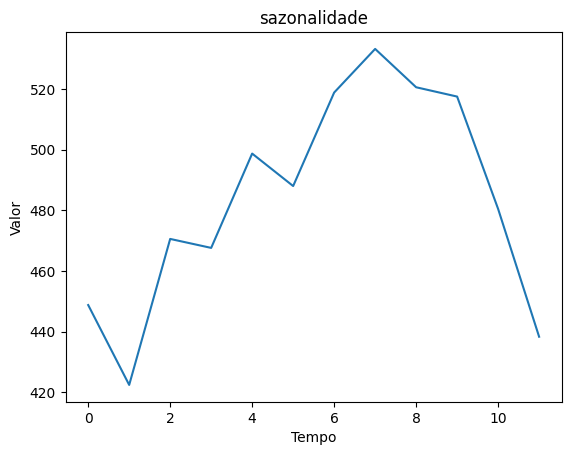

,sazonalidade
sazonalidade,
0,448.736571
1,422.395929
2,470.536321
3,467.578857
4,498.678143
5,487.972857
6,518.802429
7,533.188143
8,520.548071


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Minas Gerais - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Minas Gerais - value,Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Minas Gerais - PIB - Per Capita,Minas Gerais - PIB - Preços de Mercado,sazonalidade,Minas Gerais - Consumo de Cimento (t)
0,2003-1,0.756537,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.334536,648.891160,8.242462,2.937752e+08,1.725077e+07,14.096054,2.759117e+08,448.736571,247.134
1,2003-2,0.756708,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.335670,652.396314,8.236470,2.941480e+08,1.726959e+07,14.102603,2.760648e+08,422.395929,305.708
2,2003-3,0.756879,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.336553,655.911573,8.230479,2.945208e+08,1.728841e+07,14.109152,2.762178e+08,470.536321,284.168
3,2003-4,0.757050,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.336531,656.746430,8.224488,2.948935e+08,1.730723e+07,14.115701,2.763709e+08,467.578857,286.594
4,2003-5,0.757222,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.336406,660.114672,8.218497,2.952663e+08,1.732605e+07,14.122250,2.765239e+08,498.678143,312.455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.622619,1250.988075,NaN,NaN,NaN,NaN,NaN,533.188143,633.858
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.621866,1247.030458,NaN,NaN,NaN,NaN,NaN,520.548071,612.428
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.620866,1244.634022,NaN,NaN,NaN,NaN,NaN,517.475214,579.831
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.619585,1241.214294,NaN,NaN,NaN,NaN,NaN,480.430929,559.950


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      268.591
1      246.372
2      292.439
3      310.034
4      322.741
        ...   
235        NaN
236        NaN
237        NaN
238        NaN
239        NaN
Name: Minas Gerais - Consumo de Cimento (t), Length: 240, dtype: float64

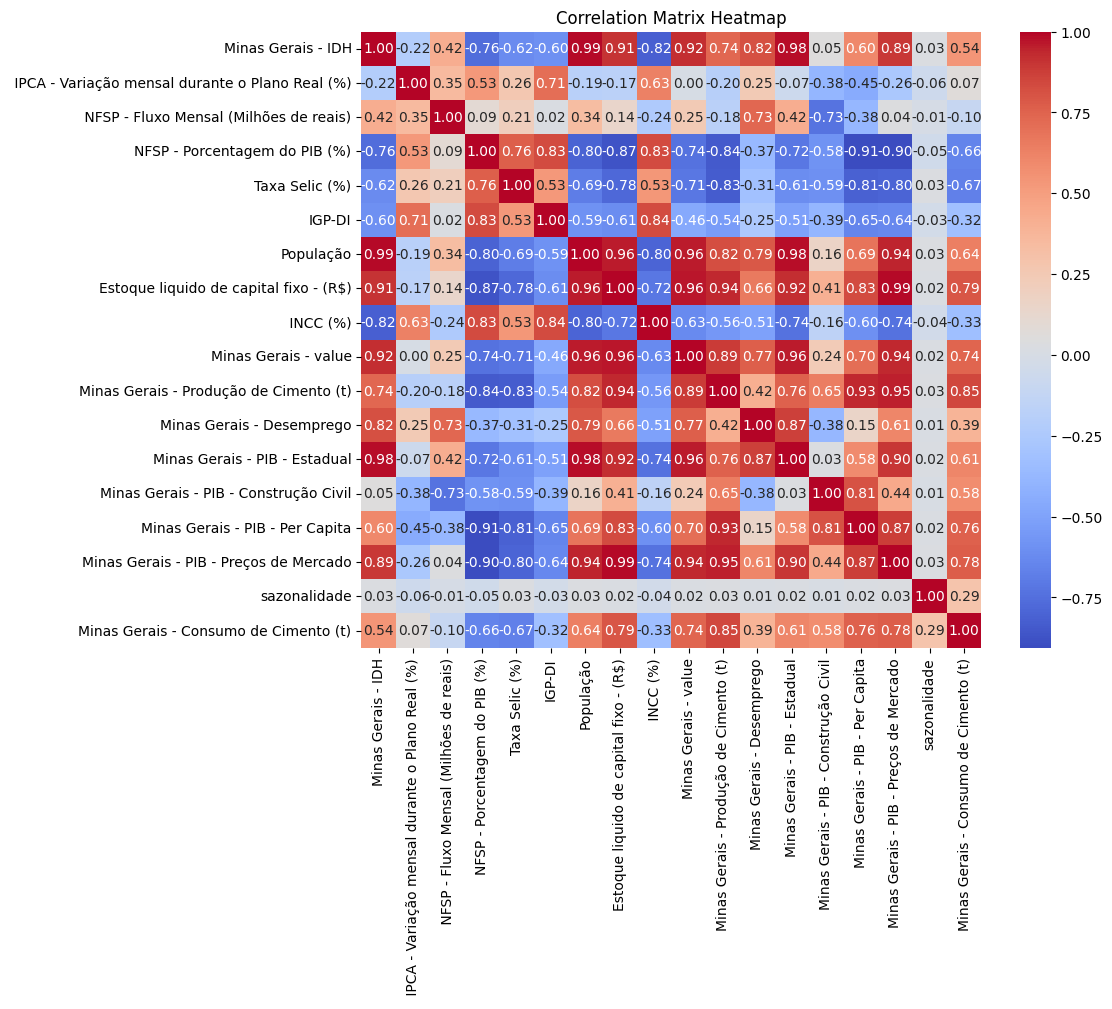

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Minas Gerais - IDH,8.903170e+06
1,IPCA - Variação mensal durante o Plano Real (%),2.113238e+03
2,NFSP - Fluxo Mensal (Milhões de reais),3.697835e+02
3,NFSP - Porcentagem do PIB (%),2.637450e+02
4,Taxa Selic (%),5.625607e+01
5,IGP-DI,4.471423e+02
6,População,2.074087e+06
7,Estoque liquido de capital fixo - (R$),2.038518e+07
8,INCC (%),8.073593e+02
9,Minas Gerais - value,1.728616e+04


In [39]:
data = remove_high_vif_columns(safe_data, 10000000)
data

Num columns removed: 2


,Minas Gerais - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,INCC (%),Minas Gerais - value,Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Minas Gerais - PIB - Preços de Mercado,sazonalidade
0,0.756537,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,0.969649,0.334536,648.891160,8.242462,2.937752e+08,1.725077e+07,2.759117e+08,448.736571
1,0.756708,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,0.950783,0.335670,652.396314,8.236470,2.941480e+08,1.726959e+07,2.760648e+08,422.395929
2,0.756879,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,0.938332,0.336553,655.911573,8.230479,2.945208e+08,1.728841e+07,2.762178e+08,470.536321
3,0.757050,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,0.926401,0.336531,656.746430,8.224488,2.948935e+08,1.730723e+07,2.763709e+08,467.578857
4,0.757222,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,0.951683,0.336406,660.114672,8.218497,2.952663e+08,1.732605e+07,2.765239e+08,498.678143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.778516,0.366904,-5783.316460,2.206994,0.545067,0.471521,1.987710e+08,0.378150,0.504771,1076.243174,9.675295,3.479272e+08,1.763275e+07,2.842671e+08,533.188143
176,0.778476,0.358935,-6001.730740,2.215328,0.782910,0.476827,1.988450e+08,0.377666,0.504929,1080.201322,9.659046,3.479130e+08,1.763790e+07,2.842707e+08,520.548071
177,0.778437,0.354313,-6454.887704,2.232466,0.909682,0.475427,1.989190e+08,0.377838,0.505091,1085.215611,9.642798,3.478988e+08,1.764305e+07,2.842743e+08,517.475214
178,0.778397,0.352728,-6243.191421,2.263185,1.050614,0.491301,1.989930e+08,0.370057,0.505254,1089.574366,9.626549,3.478847e+08,1.764820e+07,2.842780e+08,480.430929


In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,INCC (%),Minas Gerais - value,Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Minas Gerais - PIB - Preços de Mercado
0,2.802383,0.604311,4.268118,2.039314,3.921218,-2.016914,3.214079,-1.456859,-2.068725,-0.639429,-1.693066,-2.005569,-2.599173
1,2.402642,0.609431,4.096014,1.195209,3.582946,-1.988421,3.051841,-1.441424,-2.048226,-0.646115,-1.672376,-1.955577,-2.537023
2,2.158351,0.562720,3.903698,2.960381,3.422548,-1.959928,2.944772,-1.429415,-2.027668,-0.652801,-1.651685,-1.905585,-2.474873
3,2.049492,0.455907,3.693727,1.040752,3.167136,-1.931435,2.842174,-1.429714,-2.022786,-0.659487,-1.630994,-1.855593,-2.412723
4,1.905441,0.498418,3.454992,2.351150,2.986591,-1.902941,3.059587,-1.431421,-2.003087,-0.666173,-1.610304,-1.805601,-2.350574
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-1.429358,0.425789,-0.584804,-1.503380,-0.514871,1.368581,-1.872446,0.859531,0.430539,0.959580,1.312578,-0.990856,0.793795
176,-1.523783,0.339575,-0.580461,-0.733634,-0.473208,1.380202,-1.876611,0.861677,0.453687,0.941446,1.311792,-0.977176,0.795277
177,-1.578548,0.160702,-0.571531,-0.323353,-0.484199,1.391823,-1.875135,0.863883,0.483012,0.923313,1.311005,-0.963496,0.796758
178,-1.597335,0.244264,-0.555524,0.132757,-0.359568,1.403443,-1.942040,0.866099,0.508503,0.905180,1.310219,-0.949815,0.798239


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,INCC (%),Minas Gerais - value,Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Minas Gerais - PIB - Preços de Mercado
0,2.802383,0.604311,4.268118,2.039314,3.921218,-2.016914,3.214079,-1.456859,-2.068725,-0.639429,-1.693066,-2.005569,-2.599173
1,2.402642,0.609431,4.096014,1.195209,3.582946,-1.988421,3.051841,-1.441424,-2.048226,-0.646115,-1.672376,-1.955577,-2.537023
2,2.158351,0.562720,3.903698,2.960381,3.422548,-1.959928,2.944772,-1.429415,-2.027668,-0.652801,-1.651685,-1.905585,-2.474873
3,2.049492,0.455907,3.693727,1.040752,3.167136,-1.931435,2.842174,-1.429714,-2.022786,-0.659487,-1.630994,-1.855593,-2.412723
4,1.905441,0.498418,3.454992,2.351150,2.986591,-1.902941,3.059587,-1.431421,-2.003087,-0.666173,-1.610304,-1.805601,-2.350574
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,-0.960452,1.465326,-0.676734,0.472779,-1.087000,1.228701,-1.491033,0.851510,0.078902,1.299946,1.291357,-1.048685,0.729682
164,-1.007966,1.351131,-0.668750,0.302784,-0.904679,1.240408,-1.525186,0.849183,0.092192,1.257259,1.296701,-1.056272,0.740431
165,-0.976556,1.143146,-0.657609,0.339539,-0.900134,1.252114,-1.546744,0.850353,0.105936,1.214572,1.302046,-1.063859,0.751180
166,-1.146834,1.542609,-0.647588,0.472795,-1.136836,1.263821,-1.586381,0.849346,0.109740,1.171885,1.307391,-1.071446,0.761929


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      268.591
1      246.372
2      292.439
3      310.034
4      322.741
        ...   
163    537.851
164    526.265
165    559.293
166    466.646
167    416.049
Name: Minas Gerais - Consumo de Cimento (t), Length: 168, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 13)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,INCC (%),Minas Gerais - value,Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Minas Gerais - PIB - Preços de Mercado
132,1.530065,0.817451,-0.366715,-0.530011,0.174628,0.848407,-0.066954,1.149636,0.782502,1.303743,0.997317,-0.068844,0.804809
133,1.649361,1.130195,-0.350285,-0.532694,0.240832,0.861179,-0.130652,1.144758,0.755806,1.335770,1.008801,-0.119873,0.789694
134,1.622916,1.160498,-0.335122,-0.186421,0.176857,0.873950,-0.079602,1.144999,0.727264,1.367796,1.020284,-0.170901,0.774580
135,1.581460,1.131990,-0.321950,-0.719664,-0.005233,0.886722,-0.034473,1.142199,0.697959,1.399823,1.031767,-0.221929,0.759465
136,1.638292,1.384387,-0.302995,-0.798520,0.097576,0.899493,-0.177535,1.139083,0.668335,1.431850,1.043251,-0.272957,0.744351
137,1.643773,1.375487,-0.290554,-0.612129,0.431487,0.912265,-0.208868,1.123974,0.638304,1.463876,1.054734,-0.323986,0.729236
138,1.704584,1.438928,-0.281926,-0.476740,0.482414,0.925036,-0.245300,1.099339,0.608023,1.495903,1.066217,-0.375014,0.714122
139,1.841703,1.569590,-0.275931,-0.211736,0.657043,0.937808,-0.333490,1.101613,0.577264,1.527929,1.077701,-0.426042,0.699007
140,1.837218,1.584058,-0.271466,-0.484608,0.678386,0.950580,-0.296846,1.063990,0.546370,1.559956,1.089184,-0.477071,0.683893
141,1.797860,1.166380,-0.273241,-0.183907,0.727143,0.963351,-0.292462,1.035799,0.515565,1.591983,1.100667,-0.528099,0.668778


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 13)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(36, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3681733410, 3432596750, 1941389504, 1080880307, 3759298435, 3463598404, 3390088318, 407570031, 257880798, 1451553872]


Step: 0 ___________________________________________
val_loss: 10724.732421875
winner_seed: 3681733410


Step: 1 ___________________________________________
val_loss: 6979.44921875
winner_seed: 3432596750


Step: 2 ___________________________________________
val_loss: 7383.9033203125


Step: 3 ___________________________________________
val_loss: 7521.60595703125


Step: 4 ___________________________________________
val_loss: 274434368.0


Step: 5 ___________________________________________
val_loss: 7026.8388671875


Step: 6 ___________________________________________
val_loss: 7978.1181640625


Step: 7 ___________________________________________
val_loss: 6858.3291015625
winner_seed: 407570031


Step: 8 ___________________________________________
val_loss: 43565640.0


Step: 9 ___________________________________________
val_loss: 6203.89404296875
winner_seed: 145155

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 3s 147ms/step - loss: 256051.7344 - val_loss: 43577.6172
Epoch 2/10000
4/4 [==============================] - 0s 13ms/step - loss: 49640.0703 - val_loss: 7374.6880
Epoch 3/10000
4/4 [==============================] - 0s 12ms/step - loss: 10729.6084 - val_loss: 11881.8057
Epoch 4/10000
4/4 [==============================] - 0s 13ms/step - loss: 7770.6455 - val_loss: 14856.7656
Epoch 5/10000
4/4 [==============================] - 0s 13ms/step - loss: 7494.0981 - val_loss: 14994.2754
Epoch 6/10000
4/4 [==============================] - 0s 13ms/step - loss: 7586.9419 - val_loss: 14726.9766
Epoch 7/10000
4/4 [==============================] - 0s 13ms/step - loss: 7531.7646 - val_loss: 15568.5176
Epoch 8/10000
4/4 [==============================] - 0s 12ms/step - loss: 7508.5391 - val_loss: 15382.7725
Epoch 9/10000
4/4 [==============================] - 0s 13ms/step - loss: 7551.1616 - val_loss: 15699.5859
Epoch 10/10000
4/4 [=============

4/4 [==============================] - 0s 12ms/step - loss: 2562.0686 - val_loss: 7856.7065
Epoch 78/10000
4/4 [==============================] - 0s 12ms/step - loss: 2275.5056 - val_loss: 7668.6040
Epoch 79/10000
4/4 [==============================] - 0s 13ms/step - loss: 2381.8394 - val_loss: 7682.3179
Epoch 80/10000
4/4 [==============================] - 0s 13ms/step - loss: 2471.5964 - val_loss: 7857.7588
Epoch 81/10000
4/4 [==============================] - 0s 12ms/step - loss: 3776.8660 - val_loss: 7608.8423
Epoch 82/10000
4/4 [==============================] - 0s 13ms/step - loss: 3616.3977 - val_loss: 9094.3730
Epoch 83/10000
4/4 [==============================] - 0s 14ms/step - loss: 2807.2737 - val_loss: 7770.3525
Epoch 84/10000
4/4 [==============================] - 0s 14ms/step - loss: 2722.2410 - val_loss: 7790.2031
Epoch 85/10000
4/4 [==============================] - 0s 13ms/step - loss: 2684.2166 - val_loss: 7718.4531
Epoch 86/10000
4/4 [==============================] 

4/4 [==============================] - 0s 13ms/step - loss: 2882.3914 - val_loss: 7791.8682
Epoch 154/10000
4/4 [==============================] - 0s 12ms/step - loss: 2535.5627 - val_loss: 8122.6333
Epoch 155/10000
4/4 [==============================] - 0s 13ms/step - loss: 2544.7385 - val_loss: 7377.1880
Epoch 156/10000
4/4 [==============================] - 0s 12ms/step - loss: 2329.3577 - val_loss: 8095.3706
Epoch 157/10000
4/4 [==============================] - 0s 13ms/step - loss: 2702.4807 - val_loss: 7901.5259
Epoch 158/10000
4/4 [==============================] - 0s 13ms/step - loss: 2608.5642 - val_loss: 6708.6060
Epoch 159/10000
4/4 [==============================] - 0s 13ms/step - loss: 2547.0674 - val_loss: 6763.2319
Epoch 160/10000
4/4 [==============================] - 0s 12ms/step - loss: 2760.2468 - val_loss: 6755.1045
Epoch 161/10000
4/4 [==============================] - 0s 12ms/step - loss: 2699.1230 - val_loss: 6791.1128
Epoch 162/10000
4/4 [=======================

4/4 [==============================] - 0s 13ms/step - loss: 2758.7639 - val_loss: 8191.0366
Epoch 230/10000
4/4 [==============================] - 0s 13ms/step - loss: 2534.4275 - val_loss: 8230.6396
Epoch 231/10000
4/4 [==============================] - 0s 13ms/step - loss: 2644.3643 - val_loss: 8149.0498
Epoch 232/10000
4/4 [==============================] - 0s 13ms/step - loss: 2740.2861 - val_loss: 8132.2319
Epoch 233/10000
4/4 [==============================] - 0s 14ms/step - loss: 2534.7554 - val_loss: 8310.7334
Epoch 234/10000
4/4 [==============================] - 0s 13ms/step - loss: 2673.5967 - val_loss: 9057.6299
Epoch 235/10000
4/4 [==============================] - 0s 13ms/step - loss: 2325.5244 - val_loss: 8895.5283
Epoch 236/10000
4/4 [==============================] - 0s 14ms/step - loss: 2387.7197 - val_loss: 8986.9062
Epoch 237/10000
4/4 [==============================] - 0s 14ms/step - loss: 2346.7639 - val_loss: 8303.4932
Epoch 238/10000
4/4 [=======================

Epoch 305/10000
4/4 [==============================] - 0s 13ms/step - loss: 2279.5571 - val_loss: 7992.3384
Epoch 306/10000
4/4 [==============================] - 0s 13ms/step - loss: 2392.0337 - val_loss: 9331.1777
Epoch 307/10000
4/4 [==============================] - 0s 14ms/step - loss: 2539.1702 - val_loss: 9896.7393
Epoch 308/10000
4/4 [==============================] - 0s 13ms/step - loss: 2293.4333 - val_loss: 9400.9980
Epoch 309/10000
4/4 [==============================] - 0s 13ms/step - loss: 2206.4707 - val_loss: 10206.3643
Epoch 310/10000
4/4 [==============================] - 0s 14ms/step - loss: 2196.5671 - val_loss: 9320.3193
Epoch 311/10000
4/4 [==============================] - 0s 14ms/step - loss: 2174.0044 - val_loss: 10400.4004
Epoch 312/10000
4/4 [==============================] - 0s 12ms/step - loss: 2186.7952 - val_loss: 9748.7344
Epoch 313/10000
4/4 [==============================] - 0s 12ms/step - loss: 2334.2683 - val_loss: 8097.3306
Epoch 314/10000
4/4 [=====

Epoch 381/10000
4/4 [==============================] - 0s 14ms/step - loss: 2503.8835 - val_loss: 8862.5596
Epoch 382/10000
4/4 [==============================] - 0s 13ms/step - loss: 2797.7756 - val_loss: 8899.3604
Epoch 383/10000
4/4 [==============================] - 0s 18ms/step - loss: 2459.5698 - val_loss: 11419.6943
Epoch 384/10000
4/4 [==============================] - 0s 14ms/step - loss: 2708.9160 - val_loss: 10036.0850
Epoch 385/10000
4/4 [==============================] - 0s 18ms/step - loss: 2469.8997 - val_loss: 8958.3672
Epoch 386/10000
4/4 [==============================] - 0s 15ms/step - loss: 2534.7803 - val_loss: 8855.1084
Epoch 387/10000
4/4 [==============================] - 0s 12ms/step - loss: 2464.1794 - val_loss: 8870.0557
Epoch 388/10000
4/4 [==============================] - 0s 13ms/step - loss: 2406.5649 - val_loss: 9044.2168
Epoch 389/10000
4/4 [==============================] - 0s 12ms/step - loss: 2132.9739 - val_loss: 9133.5137
Epoch 390/10000
4/4 [=====

Epoch 457/10000
4/4 [==============================] - 0s 12ms/step - loss: 2298.6892 - val_loss: 11519.1572
Epoch 458/10000
4/4 [==============================] - 0s 14ms/step - loss: 2289.8826 - val_loss: 11504.1240
Epoch 459/10000
4/4 [==============================] - 0s 13ms/step - loss: 2321.3130 - val_loss: 8746.0293
Epoch 460/10000
4/4 [==============================] - 0s 12ms/step - loss: 2371.4895 - val_loss: 8768.1855
Epoch 461/10000
4/4 [==============================] - 0s 12ms/step - loss: 2306.1152 - val_loss: 8842.0732
Epoch 462/10000
4/4 [==============================] - 0s 14ms/step - loss: 2185.2622 - val_loss: 8689.3330
Epoch 463/10000
4/4 [==============================] - 0s 12ms/step - loss: 2419.3518 - val_loss: 8696.1553
Epoch 464/10000
4/4 [==============================] - 0s 12ms/step - loss: 2865.6060 - val_loss: 8664.6562
Epoch 465/10000
4/4 [==============================] - 0s 13ms/step - loss: 2363.3464 - val_loss: 8573.4434
Epoch 466/10000
4/4 [=====

Epoch 533/10000
4/4 [==============================] - 0s 12ms/step - loss: 2420.3513 - val_loss: 8183.6460
Epoch 534/10000
4/4 [==============================] - 0s 14ms/step - loss: 2331.3127 - val_loss: 8110.4233
Epoch 535/10000
4/4 [==============================] - 0s 13ms/step - loss: 2270.5752 - val_loss: 8032.3906
Epoch 536/10000
4/4 [==============================] - 0s 13ms/step - loss: 2312.2788 - val_loss: 8100.3774
Epoch 537/10000
4/4 [==============================] - 0s 12ms/step - loss: 2298.5615 - val_loss: 8113.6333
Epoch 538/10000
4/4 [==============================] - 0s 14ms/step - loss: 2251.5122 - val_loss: 8100.1597
Epoch 539/10000
4/4 [==============================] - 0s 13ms/step - loss: 2324.0281 - val_loss: 8060.7192
Epoch 540/10000
4/4 [==============================] - 0s 13ms/step - loss: 2313.4363 - val_loss: 8128.5327
Epoch 541/10000
4/4 [==============================] - 0s 14ms/step - loss: 2382.6685 - val_loss: 8051.6323
Epoch 542/10000
4/4 [=======

4/4 [==============================] - 0s 14ms/step - loss: 2439.7717 - val_loss: 9689.5840
Epoch 609/10000
4/4 [==============================] - 0s 14ms/step - loss: 2192.1931 - val_loss: 9666.3643
Epoch 610/10000
4/4 [==============================] - 0s 13ms/step - loss: 2308.0413 - val_loss: 9553.2393
Epoch 611/10000
4/4 [==============================] - 0s 13ms/step - loss: 2369.1248 - val_loss: 9633.1348
Epoch 612/10000
4/4 [==============================] - 0s 13ms/step - loss: 2264.3062 - val_loss: 9997.8730
Epoch 613/10000
4/4 [==============================] - 0s 12ms/step - loss: 2361.8906 - val_loss: 9694.6426
Epoch 614/10000
4/4 [==============================] - 0s 13ms/step - loss: 2356.4451 - val_loss: 9711.2783
Epoch 615/10000
4/4 [==============================] - 0s 14ms/step - loss: 2110.5371 - val_loss: 9719.3223
Epoch 616/10000
4/4 [==============================] - 0s 13ms/step - loss: 2251.9739 - val_loss: 9824.0859
Epoch 617/10000
4/4 [=======================

Epoch 684/10000
4/4 [==============================] - 0s 14ms/step - loss: 2211.8320 - val_loss: 9185.9189
Epoch 685/10000
4/4 [==============================] - 0s 13ms/step - loss: 2072.6177 - val_loss: 9183.4316
Epoch 686/10000
4/4 [==============================] - 0s 13ms/step - loss: 2059.1436 - val_loss: 9042.4004
Epoch 687/10000
4/4 [==============================] - 0s 13ms/step - loss: 2328.4980 - val_loss: 9019.7637
Epoch 688/10000
4/4 [==============================] - 0s 14ms/step - loss: 2113.1472 - val_loss: 9062.2734
Epoch 689/10000
4/4 [==============================] - 0s 12ms/step - loss: 2412.9119 - val_loss: 8830.2354
Epoch 690/10000
4/4 [==============================] - 0s 12ms/step - loss: 2421.6660 - val_loss: 7774.5972
Epoch 691/10000
4/4 [==============================] - 0s 12ms/step - loss: 2367.9314 - val_loss: 7591.5884
Epoch 692/10000
4/4 [==============================] - 0s 13ms/step - loss: 2190.3059 - val_loss: 8359.1562
Epoch 693/10000
4/4 [=======

Epoch 760/10000
4/4 [==============================] - 0s 12ms/step - loss: 2146.4194 - val_loss: 8592.9609
Epoch 761/10000
4/4 [==============================] - 0s 13ms/step - loss: 2118.3674 - val_loss: 8788.0498
Epoch 762/10000
4/4 [==============================] - 0s 12ms/step - loss: 2173.7063 - val_loss: 8647.8291
Epoch 763/10000
4/4 [==============================] - 0s 13ms/step - loss: 2154.7104 - val_loss: 8555.4502
Epoch 764/10000
4/4 [==============================] - 0s 13ms/step - loss: 2216.5669 - val_loss: 8674.0684
Epoch 765/10000
4/4 [==============================] - 0s 12ms/step - loss: 2176.8076 - val_loss: 8829.5312
Epoch 766/10000
4/4 [==============================] - 0s 13ms/step - loss: 2039.5082 - val_loss: 8839.7930
Epoch 767/10000
4/4 [==============================] - 0s 13ms/step - loss: 1948.1130 - val_loss: 8939.4795
Epoch 768/10000
4/4 [==============================] - 0s 13ms/step - loss: 2059.2122 - val_loss: 9219.8545
Epoch 769/10000
4/4 [=======

Epoch 836/10000
4/4 [==============================] - 0s 12ms/step - loss: 2153.4299 - val_loss: 8753.8408
Epoch 837/10000
4/4 [==============================] - 0s 13ms/step - loss: 2138.4841 - val_loss: 8838.2803
Epoch 838/10000
4/4 [==============================] - 0s 12ms/step - loss: 2008.9463 - val_loss: 8814.3682
Epoch 839/10000
4/4 [==============================] - 0s 13ms/step - loss: 2119.1497 - val_loss: 8775.7627
Epoch 840/10000
4/4 [==============================] - 0s 13ms/step - loss: 1956.1854 - val_loss: 8716.9512
Epoch 841/10000
4/4 [==============================] - 0s 13ms/step - loss: 2082.5898 - val_loss: 8661.7129
Epoch 842/10000
4/4 [==============================] - 0s 14ms/step - loss: 2066.0225 - val_loss: 8760.7979
Epoch 843/10000
4/4 [==============================] - 0s 12ms/step - loss: 2156.0881 - val_loss: 8710.9141
Epoch 844/10000
4/4 [==============================] - 0s 13ms/step - loss: 2007.0485 - val_loss: 8686.8799
Epoch 845/10000
4/4 [=======

Epoch 912/10000
4/4 [==============================] - 0s 13ms/step - loss: 1951.1141 - val_loss: 8494.9844
Epoch 913/10000
4/4 [==============================] - 0s 13ms/step - loss: 2067.1062 - val_loss: 8430.1094
Epoch 914/10000
4/4 [==============================] - 0s 13ms/step - loss: 2034.8198 - val_loss: 8629.3252
Epoch 915/10000
4/4 [==============================] - 0s 13ms/step - loss: 1677.5988 - val_loss: 8824.4014
Epoch 916/10000
4/4 [==============================] - 0s 12ms/step - loss: 1941.2302 - val_loss: 8648.2871
Epoch 917/10000
4/4 [==============================] - 0s 13ms/step - loss: 2450.3274 - val_loss: 8397.0117
Epoch 918/10000
4/4 [==============================] - 0s 12ms/step - loss: 2031.1075 - val_loss: 8256.2754
Epoch 919/10000
4/4 [==============================] - 0s 12ms/step - loss: 1952.6298 - val_loss: 8320.1777
Epoch 920/10000
4/4 [==============================] - 0s 13ms/step - loss: 2156.9380 - val_loss: 8350.1299
Epoch 921/10000
4/4 [=======

Epoch 988/10000
4/4 [==============================] - 0s 14ms/step - loss: 1782.4822 - val_loss: 8650.6562
Epoch 989/10000
4/4 [==============================] - 0s 14ms/step - loss: 1798.4698 - val_loss: 8701.9570
Epoch 990/10000
4/4 [==============================] - 0s 13ms/step - loss: 1716.1821 - val_loss: 8536.6104
Epoch 991/10000
4/4 [==============================] - 0s 13ms/step - loss: 1824.8020 - val_loss: 8259.2002
Epoch 992/10000
4/4 [==============================] - 0s 13ms/step - loss: 1954.6862 - val_loss: 8319.7324
Epoch 993/10000
4/4 [==============================] - 0s 13ms/step - loss: 1981.5912 - val_loss: 8436.4795
Epoch 994/10000
4/4 [==============================] - 0s 13ms/step - loss: 1967.2683 - val_loss: 8380.6250
Epoch 995/10000
4/4 [==============================] - 0s 13ms/step - loss: 2007.3323 - val_loss: 8222.9473
Epoch 996/10000
4/4 [==============================] - 0s 12ms/step - loss: 2255.9636 - val_loss: 8143.2373
Epoch 997/10000
4/4 [=======

4/4 [==============================] - 0s 12ms/step - loss: 1958.3369 - val_loss: 7736.6899
Epoch 1064/10000
4/4 [==============================] - 0s 13ms/step - loss: 2072.7351 - val_loss: 7834.9600
Epoch 1065/10000
4/4 [==============================] - 0s 14ms/step - loss: 1951.1248 - val_loss: 8542.7891
Epoch 1066/10000
4/4 [==============================] - 0s 13ms/step - loss: 2077.0100 - val_loss: 8537.8555
Epoch 1067/10000
4/4 [==============================] - 0s 13ms/step - loss: 2084.0447 - val_loss: 8586.2295
Epoch 1068/10000
4/4 [==============================] - 0s 13ms/step - loss: 2148.0193 - val_loss: 8577.7275
Epoch 1069/10000
4/4 [==============================] - 0s 13ms/step - loss: 1941.4897 - val_loss: 8578.0176
Epoch 1070/10000
4/4 [==============================] - 0s 12ms/step - loss: 1836.4060 - val_loss: 8568.6055
Epoch 1071/10000
4/4 [==============================] - 0s 13ms/step - loss: 1814.7186 - val_loss: 8611.4785
Epoch 1072/10000
4/4 [==============

4/4 [==============================] - 0s 13ms/step - loss: 2071.4924 - val_loss: 8617.1191
Epoch 1139/10000
4/4 [==============================] - 0s 13ms/step - loss: 2029.5328 - val_loss: 8635.5498
Epoch 1140/10000
4/4 [==============================] - 0s 15ms/step - loss: 2142.2910 - val_loss: 8647.1924
Epoch 1141/10000
4/4 [==============================] - 0s 14ms/step - loss: 1987.4910 - val_loss: 8657.7949
Epoch 1142/10000
4/4 [==============================] - 0s 13ms/step - loss: 1954.2432 - val_loss: 8643.4004
Epoch 1143/10000
4/4 [==============================] - 0s 14ms/step - loss: 2254.1201 - val_loss: 8532.2656
Epoch 1144/10000
4/4 [==============================] - 0s 14ms/step - loss: 2188.7554 - val_loss: 8954.7871
Epoch 1145/10000
4/4 [==============================] - 0s 13ms/step - loss: 2145.8721 - val_loss: 8638.5674
Epoch 1146/10000
4/4 [==============================] - 0s 14ms/step - loss: 2065.5786 - val_loss: 9072.1660
Epoch 1147/10000
4/4 [==============

4/4 [==============================] - 0s 13ms/step - loss: 2247.9932 - val_loss: 7478.4360
Epoch 1214/10000
4/4 [==============================] - 0s 13ms/step - loss: 2089.4795 - val_loss: 7483.8687
Epoch 1215/10000
4/4 [==============================] - 0s 14ms/step - loss: 2123.8689 - val_loss: 7488.1147
Epoch 1216/10000
4/4 [==============================] - 0s 13ms/step - loss: 2239.8569 - val_loss: 7462.5361
Epoch 1217/10000
4/4 [==============================] - 0s 13ms/step - loss: 2179.1831 - val_loss: 7409.1284
Epoch 1218/10000
4/4 [==============================] - 0s 13ms/step - loss: 1929.4901 - val_loss: 7476.1694
Epoch 1219/10000
4/4 [==============================] - 0s 13ms/step - loss: 1923.0901 - val_loss: 7467.4087
Epoch 1220/10000
4/4 [==============================] - 0s 13ms/step - loss: 1936.7791 - val_loss: 7437.0029
Epoch 1221/10000
4/4 [==============================] - 0s 13ms/step - loss: 1762.5010 - val_loss: 7440.9180
Epoch 1222/10000
4/4 [==============

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 17ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,454.08606,453.224518,452.933075,452.804108,452.362946,451.584198,452.781891,452.019684,451.287903,451.3078,451.480072,451.540924
Target,501.489,460.699,445.583,509.271,532.602,500.905,588.495,589.349,543.982,614.074,557.419,412.582
Error,47.402954,7.474487,7.350067,56.466888,80.239044,49.320801,135.713104,137.329315,92.694092,162.766174,105.938934,38.958923


In [54]:
display(mae)
display(mape)

76.80456

0.13923399

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 16ms/step
Ano-11: |Prediction[[5427.413]] - Target[6256.45]| =  Error: [[829.0371]]; MAPE:[[0.13250919]]


[array([[829.0371]], dtype=float32)]

829.0371

0.13250919